# Implementing Efficient Joins on Mobile App Data

No real world problem involving data begins with a single .csv file: much more common is the case of many files from various sources.  When combining data from various sources, it often becomes neccesary to __join__ our data properly. While languages such as SQL, or libraries such as pandas, have optimized ways to do this, one still may wonder the following important question: 


<h4 align="center">What's happening "behind the scenes" when we join two tables with an SQL query, or two DataFrames with a pandas method? </h4>

In this notebook, we'll be studying the algorithms behind the joins. To do this, we'll use the data from two files: 

- AppleStore.csv - a file containing data on apps from the Apple App Store
- googleplaystore.csv - a file containing data on apps from the Google Playstore

After carefully cleaning the datasets, we'll create a python *Table() class* which implements the following join algorithms:
- Nested Loop Join 
- Hash Join
- Merge Join

to perform inner and left equi-joins. We'll then demonstrate our *class* on the above datasets, and use the performance to study the time and space complexity of each algorithm. 


# Summary
In the end, we found both theoretically and experimentally that:
- Nested Loop Join has time complexity O(N^2)
- Hash Join has time complexity O(N)
- Merge Join has time complexity O(N log N)

where N is the number of rows in each table (we assumed for simplicity that both tables have a similar number of rows). We conclude that the Hash join is the most efficient algorithm for our purposes. A figure demonstrating the time complexity of our implementation of each of the above algorithms is shown below.
<div align = "center">
<img  src=photos"join_time_complexity_comparison.png" alt="drawing" width="600"/>
</div>

Its important to note that in this notebook, we only considered "equi join" conditions. For non-equi join conditions, the other algorithms show much more potential. To read more about non-equi joins, please see [this link](https://www.w3resource.com/sql/joins/perform-a-non-equi-join.php).  

The final version of the *Table() class*, which we build throughout this notebook, is found below. 

In [ ]:
class Table():
    #_______________________
    # reads in csv_filename, 
    # assigns attributes: self.header, self.rows 
    def __init__(self,csv_filename = None, encoding = 'utf8'):
        if csv_filename == None:
            self.header = []
            self.rows = []
        else:
            #use context manager to read filename to list of lists
            with open(csv_filename, encoding = encoding) as file:
                data = list(csv.reader(file))
            self.header = data[0]
            self.rows = data[1:]


    #_______________________________________
    #display a range of rows from the dataset
    def explore(self, start = 0, end = 5, show_size=False):  
        print(self.header)
        print('\n')  
        for row in self.rows[start:end]:
            print(row)
            print('\n') 

        if show_size:
            print('Number of rows:', len(self.rows))
            print('Number of columns:', len(self.header))


    #_________________________________
    #returns list of duplicated values 
    # occuring in column (id_index)
    def detect_duplicates(self, id_index = 0):
        duplicates = []
        uniques = set()
        for row in self.rows:                           #O(N)
            id = row[id_index]                              #O(1)
            if id in uniques:                               #O(1) <--- Since unique is a set
                duplicates.append(id)
            else:
                uniques.add(id)
        return duplicates
    

    #_______________________
    # helper method for joins
    # returns a list (header) for joined table
    def generate_joined_header(self, table, on_index_right, 
                               left_suffix, right_suffix):
         #append left suffix to column names
        left_table_header = self.header
        left_column_names = [column_name + '_' + left_suffix 
                                for column_name in left_table_header]

        #remove redunant column name
        right_table_header = table.header[0:on_index_right] + table.header[on_index_right + 1:]

        #append right suffix to column names
        right_column_names = [column_name + '_' + right_suffix 
                                for column_name in right_table_header]
        return left_column_names + right_column_names
    

    #_______________________________________
    #performs inner or left join 
    # using "nested loop join" algorithm 
    def nested_loop_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
        
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)

        #nested loop join algorithm
        for row_1 in self.rows:                                                         #O(N)
            no_match = True
            for row_2 in table.rows:                                                        #O(N) <--- total O(N^2)
                if row_1[on_index_left] == row_2[on_index_right]:
                    no_match= False
                    row_3 = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(row_3)
            #on left joins, keep unmatched row from self.rows
            if (no_match) and (kind == 'left'):
                row_3 = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(row_3)

        return joined_table
    
    #_______________________________________
    #performs inner or left join 
    # using "Hash Join" algorithm 
    def hash_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
        
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)
        hash_table = {}
        # build hash table on right Table()
        for row in table.rows:                                      #O(N)
            hash_table[row[on_index_right]] = row
        # probe each row on left Table() for 
        # matches in hash_table
        for row_1 in self.rows:                                     #O(N)     
            if row_1[on_index_left] in hash_table:                  #O(1) 
                    no_match= False
                    row_2 = hash_table[row_1[on_index_left]]
                    joined_row = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(joined_row)
            elif kind == 'left':
                joined_row = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(joined_row)

        return joined_table
    
    #_______________________________________
    #performs inner or left join 
    # using "Merge Join" algorithm 
    def merge_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
    
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)
        
        # helper fuction for table sorting
        def row_index(row):
            return row[-1]
        
        #sort each table
        self.rows = sorted(self.rows, key = row_index)      #O(N log N)
        table.rows = sorted(table.rows, key = row_index)    #O(N log N) <-- assuming tables ~ equal size

        j = 0
        #merge join algorithm
        for row_1 in self.rows:                         #O(N)
            no_match = True   
            row_1_index = row_1[-1]
            index_difference = row_1_index
            #dont iterate row_1 until row_2's index is bigger
            while index_difference >= 0:                    
                row_2 = table.rows[j]
                index_difference = row_1[-1] - row_2[-1]
                #if a match is found, join rows
                if (index_difference == 0):
                    no_match = False
                    joined_row = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(joined_row)
                    if j == (len(table.rows) - 1):
                        index_difference = -10
                    else:
                        j = j + 1
                # if row_2's index is too small, look further down
                elif index_difference > 0:

                    if j == (len(table.rows) - 1): #<---- if j index is at a maximum, iterate row_1
                        index_difference = -10
                    else:
                        j = j + 1
                
            #keep unmatched rows for left joins   
            if (no_match) and (kind == 'left'):
                joined_row = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(joined_row)
  
        return joined_table

# About the Datasets
The Google Play dataset contains data from about 10,000 apps. This data was collected in August 2018. The full dataset can be found [here](https://www.kaggle.com/datasets/lava18/google-play-store-apps). The following table describes each column.

| Column name | Description |
| --- | --- |
| app |Application name |
| category | Category the app belongs to |
| rating | Overall user rating of the app (as when scraped) |
| reviews |  Number of user reviews for the app (as when scraped) | 
| size | Size of the app (as when scraped) |
| installs | Number of user downloads/installs for the app (as when scraped) |
| type | Paid or free |
| price | Price of the app (as when scraped) |
|content rating| Age group the app is targeted at - Children / Mature 21+ / Adult |
| genres | An app can belong to multiple genres (apart from its main category) |

Similarly, the Apple Store dataset contains data from approximately 7,000 apps, and can be found [here](https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps). This data was collected July of 2017. The following table summarizes each column.  

| Column name | Description |
| --- | --- |
|"id" | App ID |
|"track_name"| App Name|
|"size_bytes" | Size (in Bytes) |
|"currency"| Currency Type|
|"price" | Price amount|
|"ratingcounttot" | User Rating counts (for all version)|
|"ratingcountver" | User Rating counts (for current version)|
|"user_rating" | Average User Rating value (for all version) |
|"userratingver"| Average User Rating value (for current version)|
|"ver" | Latest version code |
|"cont_rating"| Content Rating |
|"prime_genre"| Primary Genre |
|"sup_devices.num"| Number of supporting devices |
|"ipadSc_urls.num"| Number of screenshots showed for display |
|"lang.num"| Number of supported languages |
|"vpp_lic"| Vpp Device Based Licensing Enabled |

# Initial Data Exploration

Before we delve into cleaning the datasets, let's define a first version of our *Table() class*. We'll be improving on this class throughout the notebook. For now, we simply need to inspect the data, and keep the header and rows separate. 

In [1]:
import csv
class Table():
    #_______________________
    # reads in csv_filename, 
    # assigns attributes: self.header, self.rows 
    def __init__(self,csv_filename, encoding = 'utf8'):
        #use context manager to read filename to list of lists
        with open(csv_filename, encoding = encoding) as file:
            data = list(csv.reader(file))
        self.header = data[0]
        self.rows = data[1:]

    #_____________________
    #display a range of rows from the dataset
    def explore(self, start = 0, end = 5, show_size=False):  
        print(self.header)
        print('\n')  
        for row in self.rows[start:end]:
            print(row)
            print('\n') 

        if show_size:
            print('Number of rows:', len(self.rows))
            print('Number of columns:', len(self.header))

Let's use this class to take an initial look at the data. 

In [2]:
google = Table('data/googleplaystore.csv')
google.explore(end = 3,show_size=True)

['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


['Coloring book moana', 'ART_AND_DESIGN', '3.9', '967', '14M', '500,000+', 'Free', '0', 'Everyone', 'Art & Design;Pretend Play', 'January 15, 2018', '2.0.0', '4.0.3 and up']


['U Launcher Lite – FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', '4.7', '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']


Number of rows: 10841
Number of columns: 13


We can also take a look at the App Store dataset. 

In [3]:
apple = Table('data/AppleStore.csv')
apple.explore(end = 3,show_size=True)

['id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1']


['389801252', 'Instagram', '113954816', 'USD', '0.0', '2161558', '1289', '4.5', '4.0', '10.23', '12+', 'Photo & Video', '37', '0', '29', '1']


['529479190', 'Clash of Clans', '116476928', 'USD', '0.0', '2130805', '579', '4.5', '4.5', '9.24.12', '9+', 'Games', '38', '5', '18', '1']


Number of rows: 7197
Number of columns: 16


Here are a few initial observations: 
- columns like price, rating, size, installs can be converted to a numeric datatype, but are currently stored as strings. 
- The column "App" in the google dataset corresponds to the column "track_name" in the apple dataset. This will be important when joining tables later on.

Let's move on to cleaning the dataset. 

# Checking for Missing Values

To begin the cleaning process, we check to see if there are any missing values. First, for the google dataset:

In [4]:
for i,row in enumerate(google.rows):
    if len(row) != len(google.header):
        print(google.header)
        print(row)
        print(i)

['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
['Life Made WI-Fi Touchscreen Photo Frame', '1.9', '19', '3.0M', '1,000+', 'Free', '0', 'Everyone', '', 'February 11, 2018', '1.0.19', '4.0 and up']
10472


We see that for this entry, the genre is missing. Since this is only a single row, its safe to drop it. 

In [5]:
del google.rows[10472]
google.explore(start = 0, end = 0, show_size=True)

['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


Number of rows: 10840
Number of columns: 13


Notice that the row was properly removed (as shown by the explore() method). Let's do the same check for the Apple dataset. 

In [6]:
for i,row in enumerate(apple.rows):
    if len(row) != len(apple.header):
        print(apple.header)
        print(row)
        print(i)

Nothing was printed, and we conclude this dataset has no missing values!

# Detecting Duplicates 

Now, we can check for duplicates. Let's add a duplicate checking method to our table class.

In [7]:
class Table():
    #_______________________
    # reads in csv_filename, 
    # assigns attributes: self.header, self.rows 
    def __init__(self,csv_filename, encoding = 'utf8'):
        #use context manager to read filename to list of lists
        with open(csv_filename, encoding = encoding) as file:
            data = list(csv.reader(file))
        self.header = data[0]
        self.rows = data[1:]

    #________________________________________
    #display a range of rows from the dataset
    def explore(self, start = 0, end = 5, show_size=False):  
        print(self.header)
        print('\n')  
        for row in self.rows[start:end]:
            print(row)
            print('\n') 

        if show_size:
            print('Number of rows:', len(self.rows))
            print('Number of columns:', len(self.header))


    def detect_duplicates(self, id_index = 0):
        duplicates = []
        uniques = set()
        for row in self.rows:               #O(N)
            id = row[id_index]
            if id in uniques:               #O(1) <-- uniques is a set
                duplicates.append(id)
            else:
                uniques.add(id)
        return duplicates

Let's use this method to check for duplicate rows.

In [8]:
apple = Table('data/AppleStore.csv')
google = Table('data/googleplaystore.csv')
del google.rows[10472]
google_duplicates = google.detect_duplicates()
len(google_duplicates)

1181

We can see that there are over 1,000 duplicates in the Google Play Store dataset!

There are many valid criteria for deciding which rows to keep. In this notebook, we decide to keep the duplicate with the most reviews. To remove duplicates with fewer reviews, we take the following approach.
- First, we store the maximum reviews for each app in a dictionary. This is accmplished by the "maximum_reviews" function defined below.
- Then, we loop through each row and keep only those rows where the reviews are maximized. 

In [9]:
# This function returns a dictionary with:
# keys: app names
# values: maximum reviews for each app of given name
def maximum_reviews(dataset, name_index, reviews_index):
    max_reviews = {}
    for app in dataset:
        name = app[name_index]
        number_reviews = float(app[reviews_index])
        if (name in max_reviews) and (max_reviews[name] < number_reviews):
            max_reviews[name] = number_reviews
        elif name not in max_reviews:
            max_reviews[name] = number_reviews
    return max_reviews
# This function removes duplicates by keeping only apps
# where the number of reviews coincides with the maximum
def remove_duplicates(dataset, row_dict, name_index, review_index):
    data_clean = []
    data_added = []
    for app in dataset:
        name = app[name_index]
        number_reviews = float(app[review_index])
        if  (number_reviews == row_dict[name]) and (name not in data_added):
            data_clean.append(app)
            data_added.append(name)
    return data_clean

Let's use these functions to remove the duplicates from the google play dataset, and check how many rows remain. 

In [10]:
max_reviews = maximum_reviews(dataset = google.rows, name_index=0, reviews_index=3)
google_clean = remove_duplicates(dataset = google.rows, 
                                 row_dict=max_reviews, 
                                 name_index=0,review_index=3)
len(google_clean)

9659

We see that 10840 - 1181 rows remain, which is what we expect. Let's update our google.rows attribute with the clean data.

In [11]:
google.rows = google_clean

The code cell below shows us that the apple dataset has no duplicates.

In [12]:
apple.detect_duplicates()

[]

Depending on the task at hand, further data cleaning should be performed. For instance, one may want to remove to apps with English names. The purpose of this notebook, however, is to implement various join algorithms and demonstrate them on these datasets. Since the current amount of cleaning is sufficient for this task, we move on to implementing join algorithms.

For convenience, we'll save the clean tables as separate files so we can re-read them in after altering our Table() class, without having to reclean them. Since the apple dataset contained no duplicates or missing values, we're fine to use the original version. 

In [13]:
with open('data/googleplaystore_clean.csv', mode = 'w') as file:
    writer = csv.writer(file)
    data = [google.header] + google.rows
    writer.writerows(data)

# Nested Loop Joins

Nest loop joins are, as the name suggests, a brute force way of joining. This algorithm, given table_1 and table_2 does the following:
- First, loop through all the rows in table_1.
- For each row in table_1, check each row in table_2 for a matching ID.

This algorithm is implemented within our table class via the method "nested_loop_join" found below. 

In [14]:
class Table():
    #_______________________
    # reads in csv_filename, 
    # assigns attributes: self.header, self.rows 
    def __init__(self,csv_filename = None, encoding = 'utf8'):
        if csv_filename == None:
            self.header = []
            self.rows = []
        else:
            #use context manager to read filename to list of lists
            with open(csv_filename, encoding = encoding) as file:
                data = list(csv.reader(file))
            self.header = data[0]
            self.rows = data[1:]


    #_______________________________________
    #display a range of rows from the dataset
    def explore(self, start = 0, end = 5, show_size=False):  
        print(self.header)
        print('\n')  
        for row in self.rows[start:end]:
            print(row)
            print('\n') 

        if show_size:
            print('Number of rows:', len(self.rows))
            print('Number of columns:', len(self.header))


    #_________________________________
    #returns list of duplicated values 
    # occuring in column (id_index)
    def detect_duplicates(self, id_index = 0):
        duplicates = []
        uniques = set()
        for row in self.rows:                           #O(N)
            id = row[id_index]                              #O(1)
            if id in uniques:                               #O(1) <--- Since unique is a set
                duplicates.append(id)
            else:
                uniques.add(id)
        return duplicates
    

    #_______________________
    # helper method for joins
    # returns a list (header) for joined table
    def generate_joined_header(self, table, on_index_right, 
                               left_suffix, right_suffix):
         #append left suffix to column names
        left_table_header = self.header
        left_column_names = [column_name + '_' + left_suffix 
                                for column_name in left_table_header]

        #remove redunant column name
        right_table_header = table.header[0:on_index_right] + table.header[on_index_right + 1:]

        #append right suffix to column names
        right_column_names = [column_name + '_' + right_suffix 
                                for column_name in right_table_header]
        return left_column_names + right_column_names


    #_______________________________________
    #performs inner or left join 
    # using "nested loop join" algorithm 
    def nested_loop_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
        
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)

        #nested loop join algorithm
        for row_1 in self.rows:                                                         #O(N)
            no_match = True
            for row_2 in table.rows:                                                        #O(N) <--- total O(N^2)
                if row_1[on_index_left] == row_2[on_index_right]:
                    no_match= False
                    row_3 = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(row_3)
            #on left joins, keep unmatched row from self.rows
            if (no_match) and (kind == 'left'):
                row_3 = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(row_3)

        return joined_table



Notice from our comments above that this algorithm has time complexity O(N^2). Let's demonstrate our newly defined method on the datasets. 

In [19]:
apple = Table('data/AppleStore.csv')
google = Table('data/googleplaystore_clean.csv')

In [20]:
import time
start = time.time()
inner_join = apple.nested_loop_join(google, kind = 'inner', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
left_join = apple.nested_loop_join(google, kind = 'left', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
end = time.time()
print(f"total time: {end - start}")

total time: 16.992596864700317


We can use the explore method to make sure everything is working properly. 

In [21]:
inner_join.explore(show_size=True, end = 2)

['id_apple', 'track_name_apple', 'size_bytes_apple', 'currency_apple', 'price_apple', 'rating_count_tot_apple', 'rating_count_ver_apple', 'user_rating_apple', 'user_rating_ver_apple', 'ver_apple', 'cont_rating_apple', 'prime_genre_apple', 'sup_devices.num_apple', 'ipadSc_urls.num_apple', 'lang.num_apple', 'vpp_lic_apple', 'Category_google', 'Rating_google', 'Reviews_google', 'Size_google', 'Installs_google', 'Type_google', 'Price_google', 'Content Rating_google', 'Genres_google', 'Last Updated_google', 'Current Ver_google', 'Android Ver_google']


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1', 'SOCIAL', '4.1', '78158306', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'August 3, 2018', 'Varies with device', 'Varies with device']


['389801252', 'Instagram', '113954816', 'USD', '0.0', '2161558', '1289', '4.5', '4.0', '10.23', '12+', 'Photo & Video', '37', '0', '29', '1'

In [22]:
left_join.explore(show_size=True, end = 2)

['id_apple', 'track_name_apple', 'size_bytes_apple', 'currency_apple', 'price_apple', 'rating_count_tot_apple', 'rating_count_ver_apple', 'user_rating_apple', 'user_rating_ver_apple', 'ver_apple', 'cont_rating_apple', 'prime_genre_apple', 'sup_devices.num_apple', 'ipadSc_urls.num_apple', 'lang.num_apple', 'vpp_lic_apple', 'Category_google', 'Rating_google', 'Reviews_google', 'Size_google', 'Installs_google', 'Type_google', 'Price_google', 'Content Rating_google', 'Genres_google', 'Last Updated_google', 'Current Ver_google', 'Android Ver_google']


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1', 'SOCIAL', '4.1', '78158306', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'August 3, 2018', 'Varies with device', 'Varies with device']


['389801252', 'Instagram', '113954816', 'USD', '0.0', '2161558', '1289', '4.5', '4.0', '10.23', '12+', 'Photo & Video', '37', '0', '29', '1'

Its clear the new method works properly. Now we'll implement a hash join, which takes more memory but is significantly faster. 

# Hash Joins

The basic idea of a hash join is to store all the information of one table in a __hash table__. Then, the join can be completed by looping through the rows of the second table, and probing the __hash table__ to determine which rows to join. We implement this algoirthm by adding a "hash_join" method to our *Table() class* as shown in the following code cell.

In [23]:
class Table():
    #_______________________
    # reads in csv_filename, 
    # assigns attributes: self.header, self.rows 
    def __init__(self,csv_filename = None, encoding = 'utf8'):
        if csv_filename == None:
            self.header = []
            self.rows = []
        else:
            #use context manager to read filename to list of lists
            with open(csv_filename, encoding = encoding) as file:
                data = list(csv.reader(file))
            self.header = data[0]
            self.rows = data[1:]


    #_______________________________________
    #display a range of rows from the dataset
    def explore(self, start = 0, end = 5, show_size=False):  
        print(self.header)
        print('\n')  
        for row in self.rows[start:end]:
            print(row)
            print('\n') 

        if show_size:
            print('Number of rows:', len(self.rows))
            print('Number of columns:', len(self.header))


    #_________________________________
    #returns list of duplicated values 
    # occuring in column (id_index)
    def detect_duplicates(self, id_index = 0):
        duplicates = []
        uniques = set()
        for row in self.rows:                           #O(N)
            id = row[id_index]                              #O(1)
            if id in uniques:                               #O(1) <--- Since unique is a set
                duplicates.append(id)
            else:
                uniques.add(id)
        return duplicates
    

    #_______________________
    # helper method for joins
    # returns a list (header) for joined table
    def generate_joined_header(self, table, on_index_right, 
                               left_suffix, right_suffix):
         #append left suffix to column names
        left_table_header = self.header
        left_column_names = [column_name + '_' + left_suffix 
                                for column_name in left_table_header]

        #remove redunant column name
        right_table_header = table.header[0:on_index_right] + table.header[on_index_right + 1:]

        #append right suffix to column names
        right_column_names = [column_name + '_' + right_suffix 
                                for column_name in right_table_header]
        return left_column_names + right_column_names


    #_______________________________________
    #performs inner or left join 
    # using "nested loop join" algorithm 
    def nested_loop_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
        
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)

        #nested loop join algorithm
        for row_1 in self.rows:                                                         #O(N)
            no_match = True
            for row_2 in table.rows:                                                        #O(N) <--- total O(N^2)
                if row_1[on_index_left] == row_2[on_index_right]:
                    no_match= False
                    row_3 = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(row_3)
            #on left joins, keep unmatched row from self.rows
            if (no_match) and (kind == 'left'):
                row_3 = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(row_3)

        return joined_table
    
    #_______________________________________
    #performs inner or left join 
    # using "Hash Join" algorithm 
    def hash_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
        
        #initialize empty table for returning
        joined_table = Table()
        
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)
        hash_table = {}
        # build hash table on right Table()
        for row in table.rows:                                      #O(N)
            hash_table[row[on_index_right]] = row
        # probe each row on left Table()
        for row_1 in self.rows:                                     #O(N)     
            if row_1[on_index_left] in hash_table:                  #O(1) 
                    row_2 = hash_table[row_1[on_index_left]]
                    joined_row = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(joined_row)
            elif kind == 'left':
                joined_row = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(joined_row)

        return joined_table

Let's test this newly defined method on the datasets.

In [24]:
apple = Table('data/AppleStore.csv')
google = Table('data/googleplaystore_clean.csv')
start = time.time()
inner_join = apple.hash_join(google, kind = 'inner', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
left_join = apple.hash_join(google, kind = 'left', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
end = time.time()
print(f"total time: {end - start}")

total time: 0.07600593566894531


We see that the hash join is much faster than the nested loop join. Let's explore the new tables to verify that everything worked properly. 

In [25]:
inner_join.explore(show_size=True, end = 2)

['id_apple', 'track_name_apple', 'size_bytes_apple', 'currency_apple', 'price_apple', 'rating_count_tot_apple', 'rating_count_ver_apple', 'user_rating_apple', 'user_rating_ver_apple', 'ver_apple', 'cont_rating_apple', 'prime_genre_apple', 'sup_devices.num_apple', 'ipadSc_urls.num_apple', 'lang.num_apple', 'vpp_lic_apple', 'Category_google', 'Rating_google', 'Reviews_google', 'Size_google', 'Installs_google', 'Type_google', 'Price_google', 'Content Rating_google', 'Genres_google', 'Last Updated_google', 'Current Ver_google', 'Android Ver_google']


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1', 'SOCIAL', '4.1', '78158306', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'August 3, 2018', 'Varies with device', 'Varies with device']


['389801252', 'Instagram', '113954816', 'USD', '0.0', '2161558', '1289', '4.5', '4.0', '10.23', '12+', 'Photo & Video', '37', '0', '29', '1'

In [26]:
left_join.explore(show_size=True, end = 2)

['id_apple', 'track_name_apple', 'size_bytes_apple', 'currency_apple', 'price_apple', 'rating_count_tot_apple', 'rating_count_ver_apple', 'user_rating_apple', 'user_rating_ver_apple', 'ver_apple', 'cont_rating_apple', 'prime_genre_apple', 'sup_devices.num_apple', 'ipadSc_urls.num_apple', 'lang.num_apple', 'vpp_lic_apple', 'Category_google', 'Rating_google', 'Reviews_google', 'Size_google', 'Installs_google', 'Type_google', 'Price_google', 'Content Rating_google', 'Genres_google', 'Last Updated_google', 'Current Ver_google', 'Android Ver_google']


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1', 'SOCIAL', '4.1', '78158306', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'August 3, 2018', 'Varies with device', 'Varies with device']


['389801252', 'Instagram', '113954816', 'USD', '0.0', '2161558', '1289', '4.5', '4.0', '10.23', '12+', 'Photo & Video', '37', '0', '29', '1'

We observe the same resulting tables as before, but in only a fraction of the time!

# Merge Joins

The merge join algorithm avoids nested for loops by sorting the tables first. With both tables sorted, the algorithm can stop looking for a match for __row_1__ from the __left table__ as soon as it "sees" an index from the __right table__ which is __bigger__ than the index on __row_1__. This reduces the time complexity of the nested loop join significantly. However, it requires that the tables be sorted first, which requires O(N log N) time. 

Since this algorithm involves sorting an index, we'll need to convert each column corresponding to app names into integers. This will amount to adding a column to the end of each dataset. Please note that our code for merge joining below assumes an integer index in the final column. 

We implement this algorthm into our Table() class by adding the following "merge_join()" method to the bottom of our table class.

In [43]:
class Table():
    #_______________________
    # reads in csv_filename, 
    # assigns attributes: self.header, self.rows 
    def __init__(self,csv_filename = None, encoding = 'utf8'):
        if csv_filename == None:
            self.header = []
            self.rows = []
        else:
            #use context manager to read filename to list of lists
            with open(csv_filename, encoding = encoding) as file:
                data = list(csv.reader(file))
            self.header = data[0]
            self.rows = data[1:]


    #_______________________________________
    #display a range of rows from the dataset
    def explore(self, start = 0, end = 5, show_size=False):  
        print(self.header)
        print('\n')  
        for row in self.rows[start:end]:
            print(row)
            print('\n') 

        if show_size:
            print('Number of rows:', len(self.rows))
            print('Number of columns:', len(self.header))


    #_________________________________
    #returns list of duplicated values 
    # occuring in column (id_index)
    def detect_duplicates(self, id_index = 0):
        duplicates = []
        uniques = set()
        for row in self.rows:                           #O(N)
            id = row[id_index]                              #O(1)
            if id in uniques:                               #O(1) <--- Since unique is a set
                duplicates.append(id)
            else:
                uniques.add(id)
        return duplicates
    

    #_______________________
    # helper method for joins
    # returns a list (header) for joined table
    def generate_joined_header(self, table, on_index_right, 
                               left_suffix, right_suffix):
         #append left suffix to column names
        left_table_header = self.header
        left_column_names = [column_name + '_' + left_suffix 
                                for column_name in left_table_header]

        #remove redunant column name
        right_table_header = table.header[0:on_index_right] + table.header[on_index_right + 1:]

        #append right suffix to column names
        right_column_names = [column_name + '_' + right_suffix 
                                for column_name in right_table_header]
        return left_column_names + right_column_names
    

    #_______________________________________
    #performs inner or left join 
    # using "nested loop join" algorithm 
    def nested_loop_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
        
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)

        #nested loop join algorithm
        for row_1 in self.rows:                                                         #O(N)
            no_match = True
            for row_2 in table.rows:                                                        #O(N) <--- total O(N^2)
                if row_1[on_index_left] == row_2[on_index_right]:
                    no_match= False
                    row_3 = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(row_3)
            #on left joins, keep unmatched row from self.rows
            if (no_match) and (kind == 'left'):
                row_3 = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(row_3)

        return joined_table
    
    #_______________________________________
    #performs inner or left join 
    # using "Hash Join" algorithm 
    def hash_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
        
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)
        hash_table = {}
        # build hash table on right Table()
        for row in table.rows:                                      #O(N)
            hash_table[row[on_index_right]] = row
        # probe each row on left Table() for 
        # matches in hash_table
        for row_1 in self.rows:                                     #O(N)     
            if row_1[on_index_left] in hash_table:                  #O(1) 
                    no_match= False
                    row_2 = hash_table[row_1[on_index_left]]
                    joined_row = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(joined_row)
            elif kind == 'left':
                joined_row = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(joined_row)

        return joined_table
    
    #_______________________________________
    #performs inner or left join 
    # using "Merge Join" algorithm 
    def merge_join(self, table, kind = 'inner', 
                        on_index_left = 0, on_index_right = 0, 
                        left_suffix = '', right_suffix = ''):
    
        #initialize empty table for returning
        joined_table = Table()
        
       
        #use helper method to define header for new table
        joined_table.header =  self.generate_joined_header(table, on_index_right=on_index_right,
                                                           left_suffix=left_suffix,right_suffix=right_suffix)
        
        # helper fuction for table sorting
        def row_index(row):
            return row[-1]
        
        #sort each table
        self.rows = sorted(self.rows, key = row_index)      #O(N log N)
        table.rows = sorted(table.rows, key = row_index)    #O(N log N) <-- assuming tables ~ equal size

        j = 0
        #merge join algorithm
        for row_1 in self.rows:                         #O(N)
            no_match = True   
            row_1_index = row_1[-1]
            index_difference = row_1_index
            #dont iterate row_1 until row_2's index is bigger
            while index_difference >= 0:                    
                row_2 = table.rows[j]
                index_difference = row_1[-1] - row_2[-1]
                #if a match is found, join rows
                if (index_difference == 0):
                    no_match = False
                    joined_row = row_1 + row_2[0:on_index_right] + row_2[on_index_right+1:]
                    joined_table.rows.append(joined_row)
                    if j == (len(table.rows) - 1):
                        index_difference = -10
                    else:
                        j = j + 1
                # if row_2's index is too small, look further down
                elif index_difference > 0:

                    if j == (len(table.rows) - 1): #<---- if j index is at a maximum, iterate row_1
                        index_difference = -10
                    else:
                        j = j + 1

                
            #keep unmatched rows for left joins   
            if (no_match) and (kind == 'left'):
                joined_row = row_1 + ['' for _ in range(len(table.header)-1)]       
                joined_table.rows.append(joined_row)
  
        return joined_table

In the above code, in order to sort the tables and match the rows, we assumed that the last entry of each row is a sorted index. Let's create new instances of apple and google, and add a name_id column to each of them. 

In [28]:
apple = Table('data/AppleStore.csv')
google = Table('data/googleplaystore_clean.csv')

apple.header.append("name_id")
apple_apps = {}
for i,row in enumerate(apple.rows):
    row.append(2*i)                             #apple app keys are even 
    apple_apps[row[1]] = row

google.header.append("name_id")
for i,row in enumerate(google.rows):
    if row[0] in apple_apps:
        row.append(apple_apps[row[0]][-1])      #matching google apps have matching keys
    else:
        row.append(2*i + 1)                     #google apps with no match have odd keys

Now, we can test out our newly defined method. 

In [29]:
start = time.time()
inner_join = apple.merge_join(google, kind = 'inner', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
left_join = apple.merge_join(google, kind = 'left', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
end = time.time()
print(f"Total time: {end - start}")

Total time: 0.026682138442993164


In [30]:
inner_join.explore(show_size=True, end = 2)
print('\n')
left_join.explore(show_size=True, end = 2)

['id_apple', 'track_name_apple', 'size_bytes_apple', 'currency_apple', 'price_apple', 'rating_count_tot_apple', 'rating_count_ver_apple', 'user_rating_apple', 'user_rating_ver_apple', 'ver_apple', 'cont_rating_apple', 'prime_genre_apple', 'sup_devices.num_apple', 'ipadSc_urls.num_apple', 'lang.num_apple', 'vpp_lic_apple', 'name_id_apple', 'Category_google', 'Rating_google', 'Reviews_google', 'Size_google', 'Installs_google', 'Type_google', 'Price_google', 'Content Rating_google', 'Genres_google', 'Last Updated_google', 'Current Ver_google', 'Android Ver_google', 'name_id_google']


['284882215', 'Facebook', '389879808', 'USD', '0.0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1', 0, 'SOCIAL', '4.1', '78158306', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'August 3, 2018', 'Varies with device', 'Varies with device', 0]


['389801252', 'Instagram', '113954816', 'USD', '0.0', '2161558', '1289', '4.5', '4.0', '10.23', '12

The merge join seems to be working. To conclude the notebook, we'll compare all three algorithms with a time-complexity analysis.

# Time Complexity Comparison

Its theoretically clear from the above code that 
- Nested Loop Join takes O(N^2) time
- Hash Join takes O(N) time
- Merge Join takes O(N log N) time

We can setup an experiment to verify these facts. Before doing so, we'll save the files with id's for later use. 

In [31]:
with open('data/googleplaystore_clean_with_id.csv', mode = 'w') as file:
    writer = csv.writer(file)
    data = [google.header] + google.rows
    writer.writerows(data)

with open('data/AppleStoreWithId.csv', mode = 'w') as file:
    writer = csv.writer(file)
    data = [apple.header] + apple.rows
    writer.writerows(data)

Now, for different values of N, we'll sample N rows from each dataset, and keep track of how long each type of join takes.

In [55]:
import random

N = 500                    #number of rows in our dataset
stepsize = 1                #time resolution 
                    

time_complexity_merge = []        #empty lists for plotting data
time_complexity_hash = []
time_complexity_nested = []
data_size = []

while N > 0:
    apple = Table('data/AppleStoreWithId.csv')
    google = Table('data/googleplaystore_clean_with_id.csv')
    
    #random subset of datasets
    g_sample = random.sample(google.rows, k = N) 
    a_sample =  random.sample(apple.rows, k = N) 
    for i in range(N):
        g_sample[i][-1] = int(g_sample[i][-1])
        a_sample[i][-1] = int(a_sample[i][-1])

    google.rows = g_sample
    apple.rows = a_sample
                
    
    total_time_merge = 0    
    start = time.time()
    inner_join = apple.merge_join(google, kind = 'inner', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
    end = time.time()
    total_time_merge = (end - start)  
    time_complexity_merge.append(total_time_merge) 



    total_time_hash = 0
    start = time.time()
    inner_join = apple.hash_join(google, kind = 'inner', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
    end = time.time()
    total_time_hash = (end - start)     
    time_complexity_hash.append(total_time_hash)   
    

    total_time_nested = 0 
    start = time.time()
    inner_join = apple.nested_loop_join(google, kind = 'inner', 
                                        on_index_left=1, on_index_right=0, 
                                            left_suffix='apple', right_suffix='google')
    end = time.time()
    total_time_nested = (end - start)     
    time_complexity_nested.append(total_time_nested)  


    data_size.append(N)
    N = N - stepsize        #reduce N

Let's plot the result.

Text(-25, 0.00987, 'seconds')

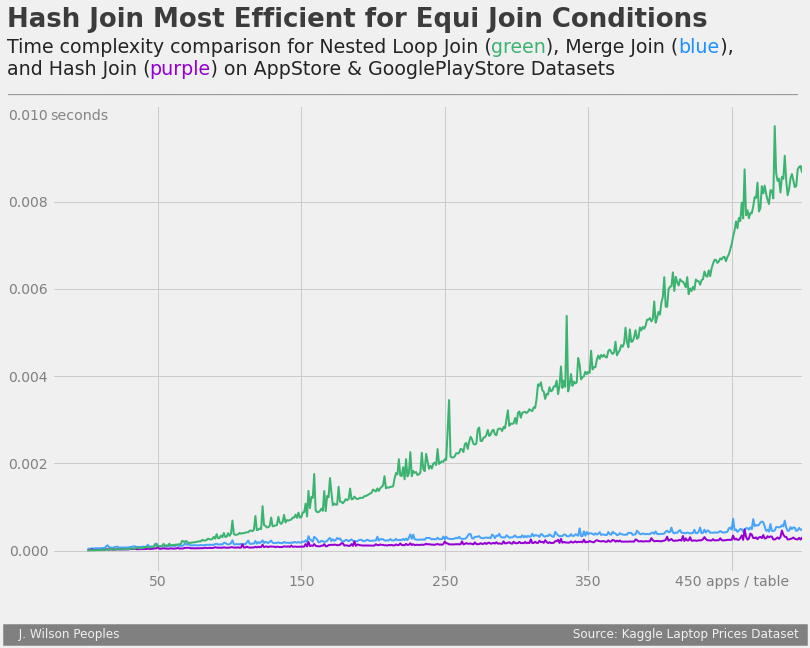

In [193]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#___________________________________________________________
#Initial Plot
fig,ax = plt.subplots(figsize = (12,8))
ax.plot(data_size,time_complexity_merge, linewidth = 2, alpha = .8, color = 'dodgerblue', label = "supress")
ax.plot(data_size,time_complexity_hash, linewidth = 2, color = 'darkviolet')
ax.plot(data_size,time_complexity_nested, linewidth = 2, color = 'mediumseagreen')
#____________________________________________________________
#Format grid, ticks, etc
ax.set_xticks([50,150,250,350, 450])
ax.set_xticklabels(['50','150','250','350','450 apps / table'])
ax.set_yticks([0,0.002,.004,.0060, .008,0.01])
ax.set_yticklabels(['0.000','0.002','0.004', '0.006','0.008', '0.010'])
ax.set_xlim(right = 500)
ax.tick_params(colors = 'grey', which = 'both')
ygridlines = ax.get_ygridlines()
gridline_of_interest = ygridlines[-1]
gridline_of_interest.set_visible(False)
#___________________________________________________________
#create title,subtitle,signature bar
ax.text(-55,.0120, 'Hash Join Most Efficient for Equi Join Conditions', weight = 'bold', size = 26, alpha = .75)
ax.text(-55,.0114, 'Time complexity comparison for Nested Loop Join (         ), Merge Join (       ),', size = 19, alpha = .85)
ax.text(-55,.0109, 'and Hash Join (          ) on AppStore & GooglePlayStore Datasets', size = 19, alpha = .85)
ax.text(x = -55, y = -.002,
    s = '   J. Wilson Peoples                                                                                                                     Source: Kaggle Laptop Prices Dataset ',
    fontsize = 12, color = '#f0f0f0', backgroundcolor = 'grey')
#_____________________________________________________________
#on figure annotations
ax.text(x = 312-30, y = .0114, s ='green', color = 'mediumseagreen', size = 19)
ax.text(x = 443-30, y = .0114, s ='blue', color = 'dodgerblue', size = 19)
ax.text(x = 74-30, y = .0109, s ='purple', color = 'darkviolet', size = 19)

ax.text(x=-55, y = .0105, color = 'grey', alpha = .8,
        s = '_________________________________________________________________________________________________________________')

ax.text(x = -25, y = .00987, s ='seconds', color = 'grey', size = 14.2, alpha = .95)


We can see that theoretical complexities line up with our observations. Namely, 
- Nested Loop Join has O(N^2) complexity
- Merge Join has O(N log N) complexity 
- Hash Join has O(N) complexity 

# Conclusion
In conclusion, we carefully cleaned two datasets containing mobile apps, and then studied various join algorithms on them. We found that, for equi-join conditions (which is the type of join considered in this notebook), the Hash Join algorithm performs best. In fact, [SQL automatically uses Hash Join for any join with only equi-join conditions!](https://dev.mysql.com/doc/refman/8.0/en/hash-joins.html#:~:text=Beginning%20with%20MySQL%208.0.18%2C%20MySQL%20employs%20a%20hash,SELECT%20%2A%20FROM%20t1%20JOIN%20t2%20ON%20t1.c1%3Dt2.c1%3B)

Throughout the process, we built a *Table() class* which implements each algorithm above and supports both left and . Its important to note that for different join conditions, the other algorithms stated are much more competetive. 

